In [ ]:
# Run this cell, if you are running the notebook on Google Colab:
!git clone https://github.com/CRC183-summer-school/school_2021.git

In [44]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(sys.path[0] + "./school_2021/notebooks/")
from IsingData import generate_Ising_configurations

# Zipping the Ising model

<h2 style="color:red"> !! The cell below takes ~10 minutes to run locally on a MacBook Pro </h2>

Try decreasing the number of samples from 1000 -> 100 to get a quick idea

In [45]:
# The temperatures that we are going to generate samples at
Ts = np.arange(1.6, 3.0, 0.1) #np.arange(1.95, 0.04, -0.1) * 2.27

# For a few different system sizes, store the data in a dictionary with L as key
all_data = {}
for L in [10, 20, 40]:#, 80]:
    all_data[L] = generate_Ising_configurations(L, 1000, Ts) # Returns half the number of samples asked for

Generating samples for L = 10 at T = 1.600
Generating samples for L = 10 at T = 1.700
Generating samples for L = 10 at T = 1.800
Generating samples for L = 10 at T = 1.900
Generating samples for L = 10 at T = 2.000
Generating samples for L = 10 at T = 2.100
Generating samples for L = 10 at T = 2.200
Generating samples for L = 10 at T = 2.300
Generating samples for L = 10 at T = 2.400
Generating samples for L = 10 at T = 2.500
Generating samples for L = 10 at T = 2.600
Generating samples for L = 10 at T = 2.700
Generating samples for L = 10 at T = 2.800
Generating samples for L = 10 at T = 2.900
Generating samples for L = 20 at T = 1.600
Generating samples for L = 20 at T = 1.700
Generating samples for L = 20 at T = 1.800
Generating samples for L = 20 at T = 1.900
Generating samples for L = 20 at T = 2.000
Generating samples for L = 20 at T = 2.100
Generating samples for L = 20 at T = 2.200
Generating samples for L = 20 at T = 2.300
Generating samples for L = 20 at T = 2.400
Generating 

In [46]:
import gzip
import shutil

sizes = {}
Ts = np.arange(1.6, 3.0, 0.1)
for L in [10, 20, 40]:#, 80]:
    sizes[L] = []

    for t,T in enumerate(Ts):
        data = all_data[L]['%.3f'%T]
        out = gzip.compress(data)
        sizes[L].append(out.__sizeof__())

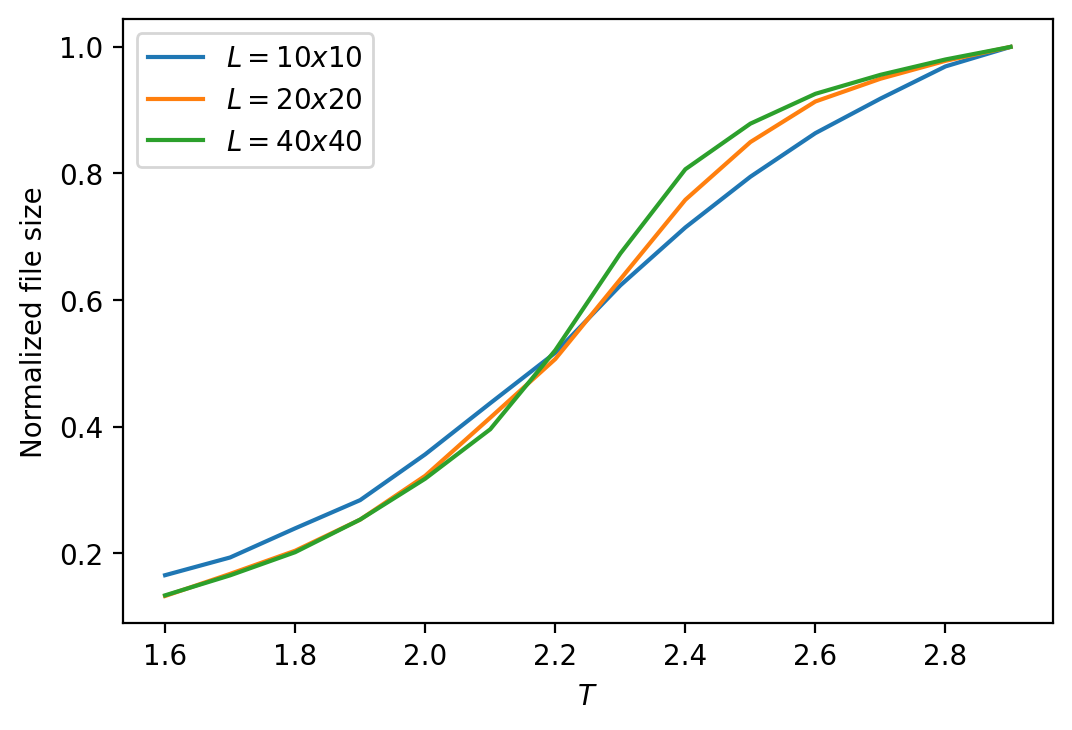

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=200)
for L in [10, 20, 40]:#, 80]:
    ax.plot(Ts, sizes[L]/np.max(sizes[L]), label='$L=%dx%d$'%(L,L))
    
ax.set_xlabel("$T$")
ax.set_ylabel("Normalized file size")
ax.legend(fancybox=True)

## Challenge idea

Add system size 80, more samples, and try a scaling collapse to extract T_c

# PCA'ing the Ising model

Be sure to also check out https://arxiv.org/abs/1606.00318

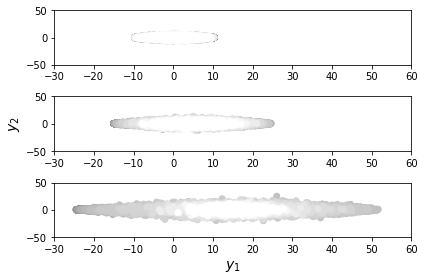

In [48]:
from sklearn.decomposition import PCA

fig, ax = plt.subplots(3,1)
Ts = np.arange(1.6, 3.0, 0.1)
principal_vectors = [] 
for a,L in enumerate([10,20,40]):
    raw_x = []
    colors = [] 
   
    for t,T in enumerate(Ts):
        data = all_data[L]['%.3f'%T]
        for c,snapshot in enumerate(data):
            raw_x.append( snapshot )
            colors.append( np.array([1, 1, 1]) * T/np.max(Ts) ) 

    pca = PCA(n_components=2)
    pca.fit(raw_x)
    proj = pca.transform(raw_x)
    principal_vectors.append( pca.components_[0] )
    ax[a].scatter(proj[:,0], proj[:,1], color=colors)
    
    ax[a].set_xlim([-30,60])
    ax[a].set_ylim([-50,50])
    
ax[1].set_ylabel("$y_2$", fontsize=14)
ax[2].set_xlabel("$y_1$", fontsize=14)
fig.tight_layout()

Text(0, 0.5, 'First principal component vector')

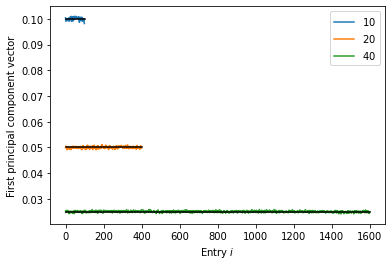

In [49]:
fig, ax = plt.subplots()

for a,L in enumerate([10,20,40]):
    ax.plot(np.abs(principal_vectors[a]), label="$%d$"%L)
    ax.plot([0, L**2], [1/L, 1/L], c='k')
    
ax.legend(fancybox=True)
ax.set_xlabel("Entry $i$")
ax.set_ylabel("First principal component vector")

We see here that the dominant principal component is quite a uniform vector. Think about what this means for when we project a sample $x$ to the latent space. If the principal component vector $P$ is uniform with value $1/L$, then $P\cdot x$ is just the (sum of x)/L. And the sum of x is the total magnetization, which we know can act as an order parameter!

# VAE'ing the Ising model

In [514]:
train_images, _, test_images, _ = mnist(permute_train=True)
data = train_images
test_data = test_images

In [50]:
# Gather all the data
# The temperatures that we are going to generate samples at
Ts = np.arange(1.0, 4.0, 0.1)

# For a few different system sizes, store the data in a dictionary with L as key
all_data_for_vae = generate_Ising_configurations(10, 2000, Ts)

Generating samples for L = 10 at T = 1.000
Generating samples for L = 10 at T = 1.100
Generating samples for L = 10 at T = 1.200
Generating samples for L = 10 at T = 1.300
Generating samples for L = 10 at T = 1.400
Generating samples for L = 10 at T = 1.500
Generating samples for L = 10 at T = 1.600
Generating samples for L = 10 at T = 1.700
Generating samples for L = 10 at T = 1.800
Generating samples for L = 10 at T = 1.900
Generating samples for L = 10 at T = 2.000
Generating samples for L = 10 at T = 2.100
Generating samples for L = 10 at T = 2.200
Generating samples for L = 10 at T = 2.300
Generating samples for L = 10 at T = 2.400
Generating samples for L = 10 at T = 2.500
Generating samples for L = 10 at T = 2.600
Generating samples for L = 10 at T = 2.700
Generating samples for L = 10 at T = 2.800
Generating samples for L = 10 at T = 2.900
Generating samples for L = 10 at T = 3.000
Generating samples for L = 10 at T = 3.100
Generating samples for L = 10 at T = 3.200
Generating 

In [67]:
data = []
test_data = []
temperatures = []
Ts = np.arange(1.6, 3.0, 0.1)
for T in Ts:
    #for i,snapshot in enumerate(all_data_for_vae['%.3f'%T]):
    for i,snapshot in enumerate(all_data[40]['%.3f'%T]):        
        if i < 900:
            data.append(snapshot)
        else: 
            test_data.append(snapshot)
            temperatures.append(T)
    
data = np.array(data)
test_data = np.array(test_data)
print(data.shape)
print(test_data.shape)

(12600, 1600)
(1400, 1600)


In [68]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax import optim
from jax import grad, jit, vmap, value_and_grad
from jax import random

class Encoder(nn.Module):
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(256, name='fc1')(x)
        x = nn.relu(x)
        mean_x = nn.Dense(self.latent_dim, name='fc2_mean')(x)
        
        # We treat this as the logarithm of the variance, because this can be a small number
        logvar_x = nn.Dense(self.latent_dim, name='fc2_logvar')(x)
        
        return mean_x, logvar_x
    
class Decoder(nn.Module):
    @nn.compact
    def __call__(self, z):
        z = nn.Dense(256, name='fc1')(z)
        z = nn.relu(z)
        z = nn.Dense(data.shape[1], name='fc2')(z)
        z = nn.tanh(z)
        return z

In [69]:
class VAE(nn.Module):
    latent_dim: int

    def setup(self):
        self.encoder = Encoder(self.latent_dim)
        self.decoder = Decoder()

    def __call__(self, x, z_rng):
        mean, logvar = self.encoder(x)
        z = reparameterize(z_rng, mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar
    
    def generate(self, z):
        return self.decoder(z)

def reparameterize(rng, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = random.normal(rng, logvar.shape)
    return mean + eps * std

In [70]:
@jax.vmap
def kl_divergence(mean, logvar):
    return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
    logits = nn.log_sigmoid(logits)
    return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))

def compute_metrics(recon_x, x, mean, logvar):
    bce_loss = binary_cross_entropy_with_logits(recon_x, x).mean()
    kld_loss = kl_divergence(mean, logvar).mean()
    return {
      'bce': bce_loss,
      'kld': kld_loss,
      'loss': bce_loss + kld_loss
    }

dim = int(np.sqrt(data.shape[1]))
@jax.jit
def eval(params, images, z, z_rng):
    def eval_model(vae):
        recon_images, mean, logvar = vae(images, z_rng)
        
        comparison = jnp.concatenate([images[:8].reshape(-1, dim,dim, 1),
                                      recon_images[:8].reshape(-1, dim,dim, 1)])

        generate_images = vae.generate(z)
        generate_images = generate_images.reshape(-1, dim,dim, 1)
        metrics = compute_metrics(recon_images, images, mean, logvar)
        return metrics, comparison, generate_images

    return nn.apply(eval_model, vae)({'params': params})

@jax.jit
def train_step(optimizer, batch, z_rng):
    def loss_fn(params):
        recon_x, mean, logvar = vae.apply({'params': params}, batch, z_rng)

        bce_loss = binary_cross_entropy_with_logits(recon_x, batch).mean()
        kld_loss = kl_divergence(mean, logvar).mean()
        loss = bce_loss + kld_loss
        return loss, recon_x

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    _, grad = grad_fn(optimizer.target)
    optimizer = optimizer.apply_gradient(grad)
    return optimizer

In [71]:
batch_size = 32
init_data = jnp.ones((batch_size, data.shape[1]), jnp.float32)

latent_dim = 1
vae = VAE(latent_dim = latent_dim)
params = vae.init(key, init_data, key)['params']

optimizer = optim.Adam(learning_rate=1e-4).create(params)
optimizer = jax.device_put(optimizer)

rng, z_key, eval_rng = random.split(key, 3)
z = random.normal(z_key, (64, latent_dim))

# Divide into batches
num_batches = len(data) // batch_size

# Loop over the training epochs
num_epochs=200
for epoch in range(num_epochs):

    # Shuffle data
    indices = np.random.permutation(len(data))
    batch_indices = jnp.split(indices[:num_batches*batch_size], batch_size)

    for b in range(len(batch_indices)):
        batch = jnp.array([data[i] for i in batch_indices[b]])
        rng, key = random.split(rng)
        optimizer = train_step(optimizer, batch, key)
        
    metrics, comparison, sample = eval(optimizer.target, test_data, z, eval_rng)

    print('eval epoch: {}, loss: {:.4f}, BCE: {:.4f}, KLD: {:.4f}'.format(
        epoch + 1, metrics['loss'], metrics['bce'], metrics['kld']
    ))

eval epoch: 1, loss: 998.6501, BCE: 995.2634, KLD: 3.3868
eval epoch: 2, loss: 842.4650, BCE: 834.6415, KLD: 7.8235
eval epoch: 3, loss: 639.3356, BCE: 628.4206, KLD: 10.9150
eval epoch: 4, loss: 484.1376, BCE: 475.5310, KLD: 8.6066
eval epoch: 5, loss: 457.3816, BCE: 448.2751, KLD: 9.1066
eval epoch: 6, loss: 450.3087, BCE: 441.3073, KLD: 9.0014
eval epoch: 7, loss: 447.5333, BCE: 438.8838, KLD: 8.6495
eval epoch: 8, loss: 445.3438, BCE: 436.9883, KLD: 8.3554
eval epoch: 9, loss: 443.7460, BCE: 435.9187, KLD: 7.8273
eval epoch: 10, loss: 442.7318, BCE: 435.1145, KLD: 7.6174
eval epoch: 11, loss: 441.5016, BCE: 434.2781, KLD: 7.2235
eval epoch: 12, loss: 440.7799, BCE: 433.7150, KLD: 7.0649
eval epoch: 13, loss: 439.9034, BCE: 432.9414, KLD: 6.9620
eval epoch: 14, loss: 439.3468, BCE: 432.7368, KLD: 6.6100
eval epoch: 15, loss: 438.9955, BCE: 432.4260, KLD: 6.5695
eval epoch: 16, loss: 438.6200, BCE: 432.3337, KLD: 6.2862
eval epoch: 17, loss: 438.3765, BCE: 432.1057, KLD: 6.2708
eval 

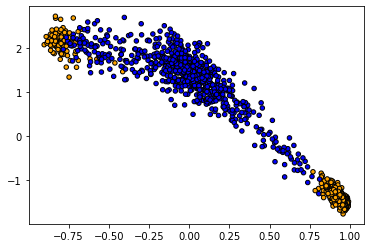

In [72]:
recon_x, mean, logvar = vae.apply({'params': optimizer.target}, test_data, z_key)
magnetization = np.mean(test_data, axis=1)
colors = ['orange' if t < 2.27 else 'blue' for t in temperatures]
plt.scatter( magnetization, mean, c=colors, edgecolors='k', s = 20 )

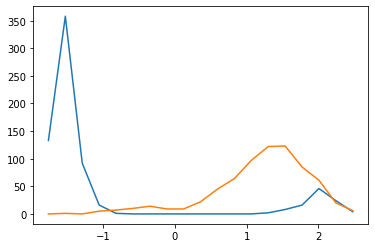

In [73]:
below_tc = np.array([mean[i,0] for i in range(len(mean)) if temperatures[i] < 2.27 ])
above_tc = np.array([mean[i,0] for i in range(len(mean)) if temperatures[i] >= 2.27 ])

b, bins = np.histogram(below_tc, bins=np.linspace(np.min(mean), np.max(mean), 20))
plt.plot(bins[:-1],b)
b, bins = np.histogram(above_tc, bins=np.linspace(np.min(mean), np.max(mean), 20))
plt.plot(bins[:-1],b)

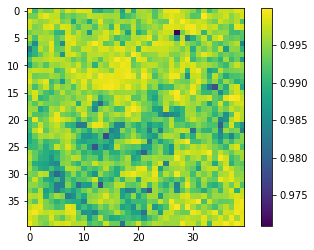

In [76]:
z = random.normal(z_key, (64, latent_dim))
def generate_samples(vae):
    generate_images = vae.generate(z)
    generate_images = generate_images.reshape(-1, 40, 40, 1)
    return generate_images

imgs = nn.apply(generate_samples, vae)({'params': optimizer.target})
plt.imshow(imgs[1])
plt.colorbar()

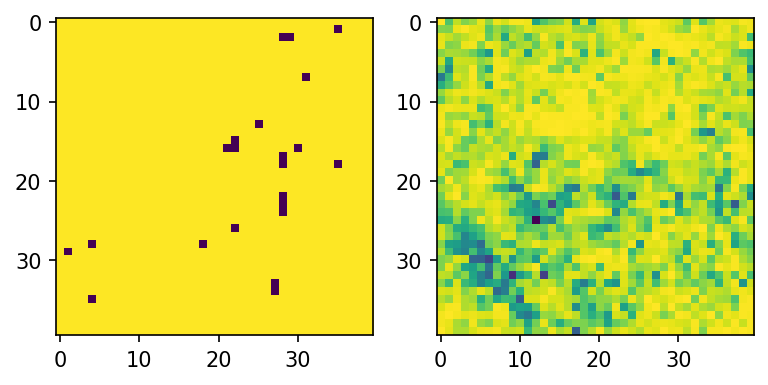

In [77]:
fig, ax = plt.subplots(1,2, dpi=150)
ax[0].imshow(np.reshape(data[0], (40,40)))
ax[1].imshow(np.reshape(recon_x[0], (40,40)))

# MNIST data loader

In [320]:
import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np

_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
    if not path.exists(_DATA):
        os.makedirs(_DATA)
    out_file = path.join(_DATA, filename)
    if not path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
    """Flatten all but the first dimension of an ndarray."""
    return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
    """Download and parse the raw MNIST dataset."""
    # CVDF mirror of http://yann.lecun.com/exdb/mnist/
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    def parse_labels(filename):
        with gzip.open(filename, "rb") as fh:
            _ = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, "rb") as fh:
            _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
        _download(base_url + filename, filename)

    train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
    train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
    test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
    test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

    return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
    """Download, parse and process MNIST data to unit scale and one-hot labels."""
    train_images, train_labels, test_images, test_labels = mnist_raw()

    train_images = _partial_flatten(train_images) / np.float32(255.)
    test_images = _partial_flatten(test_images) / np.float32(255.)
    train_labels = _one_hot(train_labels, 10)
    test_labels = _one_hot(test_labels, 10)

    if permute_train:
        perm = np.random.RandomState(0).permutation(train_images.shape[0])
        train_images = train_images[perm]
        train_labels = train_labels[perm]

    return train_images, train_labels, test_images, test_labels

# Bonus: '2NN'-ing the Ising model

In [78]:
def compute_distance(d1, d2):
    return np.count_nonzero(d1*d2+1)/(2*len(d1))
    
def nn2(data):
    N = len(data)
    distance_matrix = np.zeros((N, N))
    
    # Making the distance matrix
    for i,d1 in enumerate(data):
        for j,d2 in enumerate(data):
            if j <= i: # We don't need this because the matrix is symmetric
                continue
            else:
                distance = compute_distance(d1, d2)
                distance_matrix[i,j], distance_matrix[j,i] = distance, distance
                
    # Table of distances - state and \mu= r_2/r_1
    mu = np.zeros((N,2))
    for index, line in enumerate(distance_matrix):
        r1, r2 = sorted(line)[1:3]        
        mu[index,0] = index+1     
        mu[index,1] = 0.1
        if( r1 != 0 ):
            mu[index,1] = r2/r1
        
    # Permutation function
    sigma_i = dict(zip(range(1,len(mu)+1), np.array(sorted(mu, key=lambda x: x[1]))[:,0].astype(int)))
    mu = dict(mu)
    F_i = {}
    for i in mu:
        F_i[sigma_i[i]] = i/N

    #fitting coordinates
    x = np.log([mu[i] for i in sorted(mu.keys())])
    y = np.array([1-F_i[i] for i in sorted(mu.keys())])

    #avoid having log(0)
    x = x[y>0]
    y = y[y>0]
    y = -1*np.log(y)

    # fit line through origin to get the dimension
    m = np.linalg.lstsq(np.vstack([x, np.zeros(len(x))]).T, y, rcond=None)[0][0]
    return m, x, y

In [79]:
IDs = {}
for num_snaps in [100, 250, 500, 1000]:
    print("Num snaps: %d"%num_snaps)
    IDs[num_snaps] = []
    
    for T in Ts:
        print("\t Computing the intrinsic dimension for T = %.2f"%T)
        data =  data = all_data[10]['%.3f'%T]
        snapshots = data[:num_snaps]
        m, _, _ = nn2(snapshots)
        IDs[num_snaps].append(m)

Num snaps: 100
	 Computing the intrinsic dimension for T = 1.60
	 Computing the intrinsic dimension for T = 1.70
	 Computing the intrinsic dimension for T = 1.80
	 Computing the intrinsic dimension for T = 1.90
	 Computing the intrinsic dimension for T = 2.00
	 Computing the intrinsic dimension for T = 2.10
	 Computing the intrinsic dimension for T = 2.20
	 Computing the intrinsic dimension for T = 2.30
	 Computing the intrinsic dimension for T = 2.40
	 Computing the intrinsic dimension for T = 2.50
	 Computing the intrinsic dimension for T = 2.60
	 Computing the intrinsic dimension for T = 2.70
	 Computing the intrinsic dimension for T = 2.80
	 Computing the intrinsic dimension for T = 2.90
Num snaps: 250
	 Computing the intrinsic dimension for T = 1.60
	 Computing the intrinsic dimension for T = 1.70
	 Computing the intrinsic dimension for T = 1.80
	 Computing the intrinsic dimension for T = 1.90
	 Computing the intrinsic dimension for T = 2.00
	 Computing the intrinsic dimension for

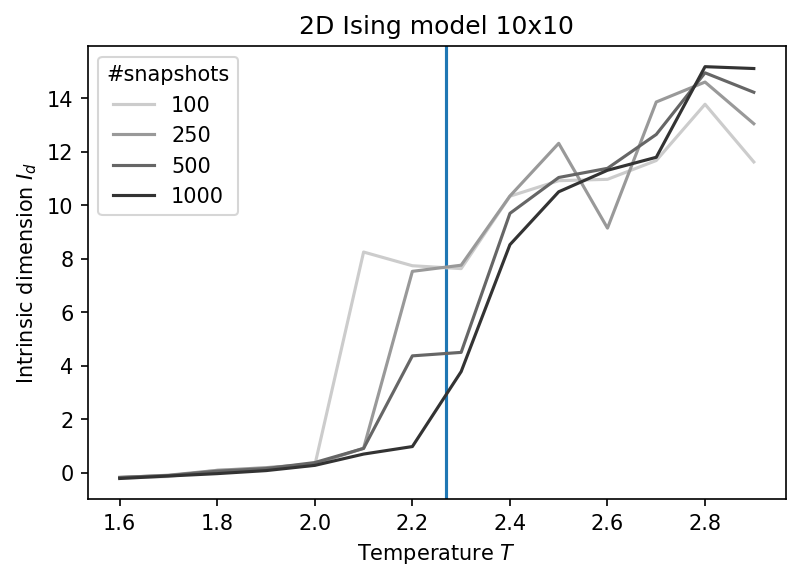

In [80]:
fig, ax = plt.subplots(dpi=150)

Tc = 2/np.log(1+np.sqrt(2))
ax.axvline(x=Tc)

colors = [(0.8, 0.8, 0.8), (0.6, 0.6, 0.6), (0.4, 0.4, 0.4), (0.2, 0.2, 0.2)]
for i,num_snaps in enumerate([100, 250, 500, 1000]):
    ax.plot(Ts, IDs[num_snaps], label="%d"%num_snaps, color=colors[i])
    
ax.set_xlabel("Temperature $T$")
ax.set_ylabel("Intrinsic dimension $I_d$")
ax.set_title("2D Ising model %dx%d"%(10,10))
ax.legend(fancybox=True, title="#snapshots")